In [25]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:95% !important; }</style>"))
import warnings
warnings.filterwarnings('ignore')

In [112]:
from astropy.table import Table
from astropy.time import Time
import numpy as np
import matplotlib.style
import matplotlib as mpl
#mpl.style.use('classic')

import matplotlib.pyplot as plt
import pandas as pd
#plt.rcParams['figure.figsize'] = [15, 15]
#size=18
#params = {'legend.fontsize': size,
#          'figure.figsize': (20,8),
#          'axes.labelsize': size,
#          'axes.titlesize': size,
#          'xtick.labelsize': size*0.75,
#          'ytick.labelsize': size*0.75,
#          'axes.titlepad': 25}
#plt.rcParams.update(params)

plt.rcParams['figure.figsize'] = [12., 12.0]
plt.rcParams['figure.dpi'] = 80
plt.rcParams['savefig.dpi'] = 100

plt.rcParams['font.size'] = '24'
plt.rcParams['legend.fontsize'] = 'large'
plt.rcParams['figure.titlesize'] = 'medium'

In [113]:
from jetset.model_parameters import ModelParameterArray, ModelParameter
from jetset.analytical_model import AnalyticalParameter
from jetset.base_model import Model
from jetset.model_manager import FitModel
from jetset.minimizer import fit_SED

In [114]:
class GrowthModel(Model):
    """
    Class to handle function for growth model
    """
    
    def __init__(self,nu_size=100,**keywords):
        """
        """
     
        super(GrowthModel,self).__init__(  **keywords)
        self.name='GrowthModel'
        self.parameters = ModelParameterArray()      
        self.eta=1
        self.parameters.add_par(AnalyticalParameter(self,name='eta',par_type='',val=1,val_min=0,val_max=10000,units=''))        
        self.R0=1
        self.parameters.add_par(AnalyticalParameter(self,name='R0',par_type='',val=3,val_min=0.,val_max=10.,units=''))       
        self.tau=1
        self.parameters.add_par(AnalyticalParameter(self,name='tau',par_type='',val=1,val_min=0.,val_max=10.,units=''))
        self.t_0=1
        self.parameters.add_par(AnalyticalParameter(self,name='t_0',par_type='',val=0,val_min=-10.,val_max=100.,units=''))
    
    def set(self,**keywords):
        super(GrowthMode,self).set(**keywords )

        """
        sets a parameter value checking for physical boundaries 
        """
        if 'val' in keywords.keys():
            self.assign_val(self.name,keywords['val']) 

    def assign_val(self,name,val):
        setattr(self.polymodel,name,val)
    
    #def lin_func(self,nu):        
    #    return -np.log10(self.eta) +(np.log10(self.R0)/self.tau)*(nu-self.eta)
    
    def lin_func(self,nu):
        return (1.0/self.eta)*np.power(self.R0,((nu-self.t_0)/self.tau))
    

In [115]:
class Data(object):
    
    def __init__(self,data,time):
        self.data=data
        self.time=time.date

In [116]:
def get_data(name='Confirmed',country='Italy',fake_error=False):
    """
    name= Confirmed, Deaths, Recovered
    """
    table=Table.read('COVID-19/csse_covid_19_data/csse_covid_19_time_series/time_series_19-covid-%s.csv'%name)
    ts=table[table['Country/Region']==country]
    df=ts.to_pandas()
    y=df.values
    y=y.flatten()[4:].astype(np.int)
    t=df.columns[4:]
    msk=y>-1
    
    time=np.arange(1,len(t)+1)
    msk=time>20
    t=t[msk]
    if fake_error is False:
        y_err= np.sqrt(y[msk])
    else:
        y_err= np.ones(y[msk].size)*0.0001
        
    data_table=Table([time[msk], y[msk], y_err, np.zeros(len(y[msk]),dtype=np.bool )],names=['nu_data','nuFnu_data','dnuFnu_data','UL'])
    data=Data(data_table,pd.to_datetime(t,format='%m/%d/%y'))
    return data

In [117]:
def plot_model(mcmc,model,data,t_start_model=None, t_stop_model=None, size=10, labels=None,label=''):
    
    if t_start_model is None:
        t_start_model = model.nu_min_fit
    
    if t_stop_model is None:
        t_stop_model = model.nu_max_fit
        
    nu=np.linspace(t_start_model,t_stop_model,100)

    mcmc.reset_to_best_fit()
    p=np.log10(model.GrowthModel.parameters.R0.best_fit_val)/model.GrowthModel.parameters.tau.val
    y = np.zeros((size,nu.size))

    for ID,ID_rand in enumerate(np.random.randint(len(mcmc.samples), size=size)):
        for ID_par,pi in  enumerate(mcmc.par_array):
            pi.set(val = mcmc.get_par(ID_par)[0][ID_rand])
  
        y[ID] = model.eval(nu,get_model=True)
    
    #print(ID)
    y_min=np.amin(y, axis=0)
    y_max=np.amax(y, axis=0)
    plt.fill_between(nu,y_max,y_min,color='gray',alpha=0.3)
    
    mcmc.reset_to_best_fit()
    y_bf=model.eval(nu,get_model=True)
    
    plt.plot(nu,y_bf,label= label+': Predicted, log10(R0)/tau=%3.3f'%p)
    
    plt.errorbar(data.data['nu_data'],data.data['nuFnu_data'],yerr=data.data['dnuFnu_data'],fmt='o',label = label+': Observed')
    
    plt.axvline(model.nu_min_fit,alpha=0.5)
    plt.axvline(model.nu_max_fit,alpha=0.5)
    
    
    locs, labels = plt.xticks()
    delta_t=data.time +pd.Timedelta(days=30)
    t=np.append(data.time,delta_t)
    delta_x=np.arange(1,31)+data.data['nu_data'][-1]
    x=np.append(data.data['nu_data'],delta_x)
    plt.xticks(x, t, rotation='vertical') 
    plt.xlabel('date')
    plt.ylabel('Counts')
    plt.semilogy()
    plt.legend(loc='center left', bbox_to_anchor=(1.0, 0.5), ncol=1)
    mcmc.reset_to_best_fit()
    #plt.suptitle('data from https://github.com/CSSEGISandData/COVID-19')

In [118]:
from jetset.minimizer import fit_SED
from jetset.mcmc import McmcSampler


In [131]:
def do_analysis(t_start,t_stop,name,country='Italy',do_plot=True):

    data=get_data(name,country,fake_error=False)
    gm=GrowthModel()
    gm.nu_min=0
    gm.nu_max=100
    #gm.parameters.eta.val=1.0
    #gm.parameters.eta.frooze=True
    fm=FitModel(analytical=gm,name='test')
    bfm,mm=fit_SED(fm,data,nu_fit_start=t_start,nu_fit_stop=t_stop,minimizer='minuit',silent=True)
    log_R0_by_tau=np.log10(gm.parameters.R0.val)/gm.parameters.tau.val
    print('log10(R0)/tau',log_R0_by_tau)
    print('doubling time',np.log10(2)/log_R0_by_tau)

    bfm.fit_Model.show_best_fit_pars()
     
    mcmc=McmcSampler(bfm)
    mcmc.run_sampler(nwalkers=150,burnin=10,steps=500,bound=3,bound_rel=True,walker_start_bound=0.001,threads=1)
        
    if do_plot is True:
        %matplotlib inline
        fig=plt.figure(figsize=(12,6))
        plot_model(mcmc,bfm.fit_Model,data,t_start_model=t_start,t_stop_model= t_stop +5,label=name,size=500)
        plt.tight_layout()
        plt.title('input data from https://github.com/CSSEGISandData/COVID-19')
        
        
        f=mcmc.corner_plot(quantiles=(0.16,0.5,0.84))
        
        fig=plt.figure(figsize=(12,6))
        nu=data.data['nu_data']
        plt.semilogy(np.gradient(bfm.fit_Model.eval(nu,get_model=True)),label='model')
        plt.semilogy(np.gradient(data.data['nuFnu_data']),'o',label='data')
        plt.xlabel('Time')
        plt.ylabel('derivative')
        plt.legend()
    return bfm,mcmc

  1%|          | 5/500 [00:00<00:09, 49.61it/s]

log10(R0)/tau 0.13651419897156716
doubling time 2.205118573245842
 model name name bestfit val     err +     err -  start val   fit range min fit range max frozen
----------- ---- ------------ ------------ ----- ------------ ------------- ------------- ------
GrowthModel  eta 1.441737e+01 2.647408e+01    -- 1.000000e+00  0.000000e+00  1.000000e+04  False
GrowthModel   R0 1.596901e+00 1.047706e+00    -- 3.000000e+00  0.000000e+00  1.000000e+01  False
GrowthModel  tau 1.489061e+00 1.978264e+00    -- 1.000000e+00  0.000000e+00  1.000000e+01  False
GrowthModel  t_0 1.986993e+01 5.907420e+00    -- 0.000000e+00 -1.000000e+01  1.000000e+02  False
mcmc run starting


100%|██████████| 500/500 [00:08<00:00, 56.81it/s]


mcmc run done, with 1 threads took 8.83 seconds


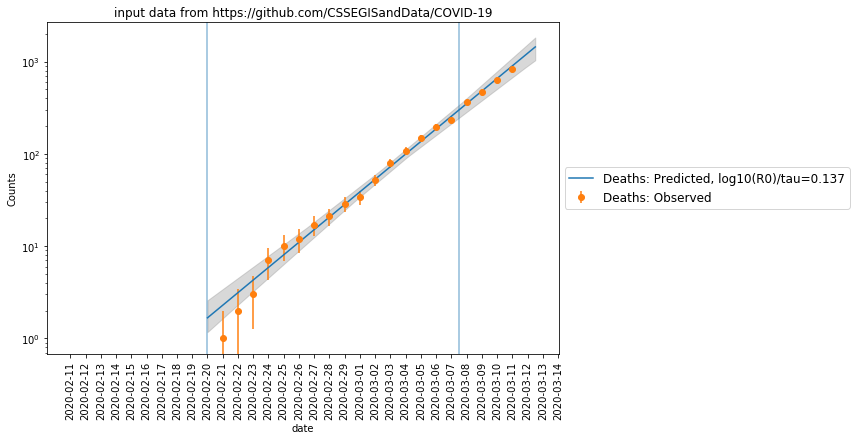

In [ ]:
bfm,mcmc=do_analysis(t_start=30,t_stop=46.5,name='Deaths')